### Import all the libraries

In [1]:
#Import all the needed libraries and functions
#Import SKlearn
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA #used for dimension reduction

#Import Pandas and Matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

#import Models
from sklearn import svm, tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor

#import Bokeh
from bokeh.io import output_notebook, show, push_notebook, reset_output
from bokeh.plotting import figure
from bokeh.embed import components
output_notebook()
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6

#create custom function for future usage..
def transform_label_encoder(value):
    le = LabelEncoder()
    le.fit(value)
    return le.transform(value)

def transform_to_standard_scaler(train, test):
    scaler = StandardScaler()
    return scaler.fit_transform(train), scaler.transform(test)

def transform_to_minmax_scaler(train, test):
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(train), min_max_scaler.transform(test)

def transform_to_pca(train, test, n=1):
    pca = PCA(n_components=n)
    return pca.fit_transform(train), pca.transform(test)

def print_line():
    for x in range (1, 30):  
        print("-",end=" ")
    print()

def print_accuracy(model, X, y, model_name, data_type_set):
    print('Accuracy of '+str(model_name)+' on '+str(data_type_set)+' set: {:.4f}'.format(model.score(X, y)))

def print_model_score(model, X_train, y_train, X_test, y_test, model_name):
    print_accuracy(model, X_train, y_train, model_name, 'training')
    print_accuracy(model, X_test, y_test, model_name, 'test')
    print_line()

def print_model_score_without_line(model, X_train, y_train, X_test, y_test, model_name):
    print_accuracy(model, X_train, y_train, model_name, 'training')
    print_accuracy(model, X_test, y_test, model_name, 'test')   

def plot_confusion_matrix(X, y, model):
    mat = confusion_matrix(y, model.predict(X))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    sns.plt.show()
    tn, fp, fn, tp = mat.ravel()
    print('Total True Positive and True Negative:',str(tn + tp))
    print('Total False Positive and False Negative:',str(fp + fn))
    print('Accurancy:',str((tn + tp) / (tn + tp + fp + fn)))

def find_column_null(df):
    return df.columns[df.isnull().any()].tolist()

def calculate_model_scores(list_of_models, X_train, y_train, X_test, y_test):
    
    highest_train_score = 0
    highest_train_model = ''
    
    highest_test_score = 0
    highest_test_model = ''
    
    highest_precision_score = 0
    highest_precision_model = ''
    
    for m_name, model in list_of_models:
        #calculate y prediction
        y_predict = model.predict(X_test)
        
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        p_score = precision_score(y_test, y_predict, average='weighted')
        
        if(train_score > highest_train_score):
            highest_train_score = train_score
            highest_train_model = m_name
        
        if(test_score > highest_test_score):
            highest_test_score = test_score
            highest_test_model = m_name
        
        if(p_score > highest_precision_score):
            highest_precision_score = p_score
            highest_precision_model = m_name
        
        print(str(m_name) + ' Accuracy score (training set):', train_score)
        print(str(m_name) + ' Accuracy score (test set):', test_score)
        print(str(m_name) + ' F1 score:', f1_score(y_test, y_predict, average='weighted'))
        print(str(m_name) + ' Recall:', recall_score(y_test, y_predict, average='weighted'))
        print(str(m_name) + ' Precision:', p_score)
        print(str(m_name) + ' ROC and AUC score:', roc_auc_score(y_test, y_predict))
        print_line()
    
    print_line()
    print('Highest Accuracy score (training set):', str(highest_train_model), '. Score: ', highest_train_score)
    print('Highest Accuracy score (test set):', str(highest_test_model), '. Score: ', highest_test_score)
    print('Highest Accuracy score (Precision):', str(highest_precision_model), '. Score: ', highest_precision_score)
    
#End class

Loading BokehJS ...

# Dota2 Games Results Data Set 

Data Set Information:

Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and weaknesses. The dataset is reasonably sparse as only 10 of 113 possible heroes are chosen in a given game. All games were played in a space of 2 hours on the 13th of August, 2016

URL: https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

Attribute Information:

Each row of the dataset is a single game with the following features (in the order in the vector):
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5. end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' 
played as that hero and '-1' for the other team. Hero can be selected by only one player each game. 
This means that each row has five '1' and five '-1' values.

Radiant = 1, Dire = -1

In [2]:
## Read the dataset
train = pd.read_csv('dota2Train.csv', header=None)
test = pd.read_csv('dota2Test.csv', header=None)

columns = ['team_won', 'cluster_id', 'game_mode', 'game_type',
           'antimage','axe','bane','bloodseeker','crystal_maiden','drow_ranger',
           'earthshaker','juggernaut','mirana','nevermore','morphling',
           'phantom_lancer','puck','pudge','razor','sand_king',
           'storm_spirit','sven','tiny','vengefulspirit',
           'windrunner','zeus','kunkka','lina','lich','lion',
           'shadow_shaman','slardar','tidehunter','witch_doctor',
           'riki','enigma','tinker','sniper','necrolyte','warlock',
           'beastmaster','queenofpain','venomancer','faceless_void',
           'skeleton_king','death_prophet','phantom_assassin','pugna',
           'templar_assassin','viper','luna','dragon_knight','dazzle',
           'rattletrap','leshrac','furion','life_stealer','dark_seer',
           'clinkz','omniknight','enchantress','huskar','night_stalker',
           'broodmother','bounty_hunter','weaver','jakiro','batrider',
           'chen','spectre','doom_bringer','ancient_apparition','ursa',
           'spirit_breaker','gyrocopter','alchemist','invoker','silencer',
           'obsidian_destroyer','lycan','brewmaster','shadow_demon','lone_druid',
           'chaos_knight','meepo','treant','ogre_magi','undying','rubick','disruptor',
           'nyx_assassin','naga_siren','keeper_of_the_light','wisp','visage','slark',
           'medusa','troll_warlord','centaur','magnataur','shredder','bristleback',
           'tusk','skywrath_mage','abaddon','elder_titan','legion_commander','ember_spirit',
           'earth_spirit','abyssal_underlord','terrorblade','phoenix','techies','oracle',
           'winter_wyvern','arc_warden', 'unknown_hero'
          ]

train.columns = columns
test.columns = columns

train.head()
test.head()

,team_won,cluster_id,game_mode,game_type,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,...,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden,unknown_hero
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Analysis

In [3]:
#Check the shape of the data
print(train.shape)
print(test.shape)

(92650, 117)
(10294, 117)


In [4]:
train.describe()

,team_won,cluster_id,game_mode,game_type,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,...,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden,unknown_hero
count,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,...,92650.000000,92650.000000,92650.000000,92650.000000,92650.0,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000
mean,0.053038,175.864145,3.317572,2.384587,-0.001630,-0.000971,0.000691,-0.000799,-0.002008,0.003173,...,-0.001371,-0.000950,0.000885,0.000594,0.0,0.001025,0.000648,-0.000227,-0.000043,0.000896
std,0.998598,35.658214,2.633070,0.486833,0.402004,0.467672,0.165052,0.355393,0.329348,0.483950,...,0.535024,0.206112,0.283985,0.155940,0.0,0.220703,0.204166,0.168707,0.189868,0.139033
min,-1.000000,111.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,152.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,156.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,223.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,261.000000,9.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#Top 6 Most pick hero
hero_lists = ['antimage','axe','bane','bloodseeker','crystal_maiden','drow_ranger',
           'earthshaker','juggernaut','mirana','nevermore','morphling',
           'phantom_lancer','puck','pudge','razor','sand_king',
           'storm_spirit','sven','tiny','vengefulspirit',
           'windrunner','zeus','kunkka','lina','lich','lion',
           'shadow_shaman','slardar','tidehunter','witch_doctor',
           'riki','enigma','tinker','sniper','necrolyte','warlock',
           'beastmaster','queenofpain','venomancer','faceless_void',
           'skeleton_king','death_prophet','phantom_assassin','pugna',
           'templar_assassin','viper','luna','dragon_knight','dazzle',
           'rattletrap','leshrac','furion','life_stealer','dark_seer',
           'clinkz','omniknight','enchantress','huskar','night_stalker',
           'broodmother','bounty_hunter','weaver','jakiro','batrider',
           'chen','spectre','doom_bringer','ancient_apparition','ursa',
           'spirit_breaker','gyrocopter','alchemist','invoker','silencer',
           'obsidian_destroyer','lycan','brewmaster','shadow_demon','lone_druid',
           'chaos_knight','meepo','treant','ogre_magi','undying','rubick','disruptor',
           'nyx_assassin','naga_siren','keeper_of_the_light','wisp','visage','slark',
           'medusa','troll_warlord','centaur','magnataur','shredder','bristleback',
           'tusk','skywrath_mage','abaddon','elder_titan','legion_commander','ember_spirit',
           'earth_spirit','abyssal_underlord','terrorblade','phoenix','techies','oracle',
           'winter_wyvern','arc_warden', 'unknown_hero'
]

top_6 = pd.DataFrame({'hero':hero_lists,'total_pick':0})
top_6.total_pick = top_6.total_pick.astype(int)

#for index, row in train.iterrows():
#    for hero in hero_lists:
#        if(row[hero] == 1 or row[hero] == -1):
#            print(hero)
#            mask = (top_5.hero == hero)
#            top_5[mask].total_pick = top_5[mask].total_pick + 1
            

In [6]:
for hero in hero_lists:
    total_pick = train[(train[hero] == 1) | (train[hero] == -1)][hero].count()
    top_6.loc[top_6[top_6.hero == hero].index, 'total_pick'] = total_pick

top_6.head()

,hero,total_pick
0,antimage,14973
1,axe,20264
2,bane,2524
3,bloodseeker,11702
4,crystal_maiden,10050


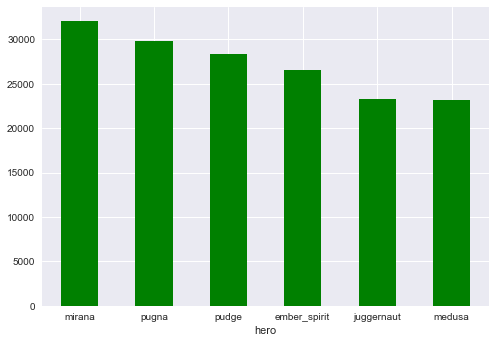

,hero,total_pick
8,mirana,32048
43,pugna,29802
13,pudge,28285
103,ember_spirit,26521
7,juggernaut,23327


In [7]:
#plot a graph for top 6 heros highest picked during the game
top_6_highest_pick = top_6.nlargest(6, 'total_pick')

df = pd.DataFrame({ 'hero':top_6_highest_pick.hero, 'total_pick':top_6_highest_pick.total_pick})
df = df[["hero","total_pick"]]
df.set_index(["hero"],inplace=True)
df.plot(kind='bar',color='g', rot=0, legend=False)
plt.show()

top_6_highest_pick.head()

In [8]:
heroes = list(df.index)
counts = list(df.total_pick)

source = ColumnDataSource(data=dict(heroes=heroes, counts=counts, color=Spectral6))

p = figure(x_range=heroes, plot_height=450, plot_width=750, title="Top 6 most pick heroes")
p.vbar(x='heroes', top='counts', width=0.5, color='color', source=source)

show(p)

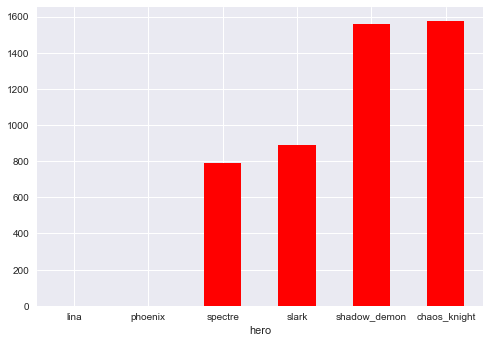

,hero,total_pick
23,lina,0
107,phoenix,0
65,spectre,790
91,slark,888
77,shadow_demon,1558


In [9]:
#plot a graph for top 5 heros lowest picked during the game
top_6_smallest_pick = top_6.nsmallest(6, 'total_pick')

df = pd.DataFrame({ 'hero':top_6_smallest_pick.hero, 'total_pick':top_6_smallest_pick.total_pick})
df = df[["hero","total_pick"]]
df.set_index(["hero"],inplace=True)
df.plot(kind='bar',color='r', rot=0, legend=False)
plt.show()

top_6_smallest_pick.head()

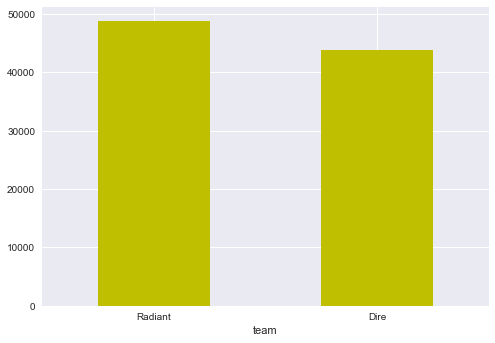

,total_won
team,
Radiant,48782
Dire,43868


In [10]:
#Team won the most
teams = pd.DataFrame({'team': ['Radiant','Dire'], 'total_won': 0})

teams.loc[teams[teams.team == 'Radiant'].index, 'total_won'] = train[train.team_won == 1].team_won.count()
teams.loc[teams[teams.team == 'Dire'].index, 'total_won'] = train[train.team_won == -1].team_won.count()
teams.set_index(["team"],inplace=True)
teams.plot(kind='bar',color='y', rot=0, legend=False)
plt.show()

teams.head()

## Data Preprocessing: Feature Engineering

Feature Engineering by converting the categorical variables

In [11]:
train['radiant_int'] = 0
train['dire_int'] = 0

test['radiant_int'] = 0
test['dire_int'] = 0

train['radiant_str'] = 0
train['dire_str'] = 0

test['radiant_str'] = 0
test['dire_str'] = 0

train['radiant_agi'] = 0
train['dire_agi'] = 0

test['radiant_agi'] = 0
test['dire_agi'] = 0

In [12]:
train.head()

,team_won,cluster_id,game_mode,game_type,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,...,oracle,winter_wyvern,arc_warden,unknown_hero,radiant_int,dire_int,radiant_str,dire_str,radiant_agi,dire_agi
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Sampling train/test data and reduce it to 45%
train = train.sample(frac=0.45, random_state=1)
test = test.sample(frac=0.45, random_state=1)

In [14]:
print(train.shape)
print(test.shape)

(41692, 123)
(4632, 123)


In [15]:
#Categorize all the heroes selections
agis = ['antimage', 'bloodseeker', 'drow_ranger', 
        'juggernaut', 'mirana', 'nevermore', 'morphling', 'phantom_lancer',
        'razor', 'vengefulspirit', 'riki','sniper','venomancer','faceless_void',
        'phantom_assassin','templar_assassin','viper','luna','clinkz','broodmother','bounty_hunter','weaver',
        'spectre','doom_bringer','ursa','gyrocopter','lone_druid','meepo','undying','nyx_assassin','naga_siren',
        'slark','medusa','troll_warlord','terrorblade','unknown_hero']

strs = ['axe', 'earthshaker', 'pudge', 'sand_king', 
        'sven', 'tiny', 'kunkka', 'slardar', 'tidehunter', 'beastmaster', 
        'skeleton_king', 'dragon_knight', 'rattletrap', 'life_stealer', 'omniknight', 'huskar', 'night_stalker', 'batrider',
        'spirit_breaker', 'alchemist', 'lycan', 'brewmaster', 'chaos_knight', 'treant','centaur','magnataur',
        'bristleback','shredder', 'tusk', 'abaddon', 'legion_commander', 'elder_titan', 'phoenix']

ints = ['crystal_maiden', 'bane', 'puck', 'storm_spirit', 
        'windrunner', 'zeus', 'lina', 'lich', 'lion', 'shadow_shaman', 
        'witch_doctor', 'enigma', 'tinker', 'necrolyte', 'warlock', 'queenofpain', 
        'death_prophet', 'pugna', 'dazzle', 'leshrac', 'furion', 'dark_seer', 'enchantress', 'jakiro', 
        'chen', 'ancient_apparition', 'invoker', 'silencer', 'obsidian_destroyer', 'shadow_demon', 'rubick', 'disruptor',
        'keeper_of_the_light', 'wisp','visage','skywrath_mage','ember_spirit','earth_spirit',
        'abyssal_underlord','winter_wyvern','ogre_magi','techies', 'oracle','arc_warden']

def categorize_heroes(data):
    for index, row in data.iterrows():
        for i in agis:
            if(row[i] == 1):
                row['radiant_agi'] = row['radiant_agi'] + 1

            if(row[i] == -1):
                row['dire_agi'] = row['dire_agi'] + 1

        for i in strs:
            if(row[i] == 1):
                row['radiant_str'] = row['radiant_str'] + 1

            if(row[i] == -1):
                row['dire_str'] = row['dire_str'] + 1

        for i in ints:
            if(row[i] == 1):
                row['radiant_int'] = row['radiant_int'] + 1

            if(row[i] == -1):
                row['dire_int'] = row['dire_int'] + 1

categorize_heroes(train)
categorize_heroes(test)

In [16]:
train = train.drop(['cluster_id','game_mode','game_type'], axis=1)
test = test.drop(['cluster_id','game_mode','game_type'], axis=1)

In [17]:
train = train.drop(['antimage','axe','bane','bloodseeker','crystal_maiden','drow_ranger',
           'earthshaker','juggernaut','mirana','nevermore','morphling',
           'phantom_lancer','puck','pudge','razor','sand_king',
           'storm_spirit','sven','tiny','vengefulspirit',
           'windrunner','zeus','kunkka','lina','lich','lion',
           'shadow_shaman','slardar','tidehunter','witch_doctor',
           'riki','enigma','tinker','sniper','necrolyte','warlock',
           'beastmaster','queenofpain','venomancer','faceless_void',
           'skeleton_king','death_prophet','phantom_assassin','pugna',
           'templar_assassin','viper','luna','dragon_knight','dazzle',
           'rattletrap','leshrac','furion','life_stealer','dark_seer',
           'clinkz','omniknight','enchantress','huskar','night_stalker',
           'broodmother','bounty_hunter','weaver','jakiro','batrider',
           'chen','spectre','doom_bringer','ancient_apparition','ursa',
           'spirit_breaker','gyrocopter','alchemist','invoker','silencer',
           'obsidian_destroyer','lycan','brewmaster','shadow_demon','lone_druid',
           'chaos_knight','meepo','treant','ogre_magi','undying','rubick','disruptor',
           'nyx_assassin','naga_siren','keeper_of_the_light','wisp','visage','slark',
           'medusa','troll_warlord','centaur','magnataur','shredder','bristleback',
           'tusk','skywrath_mage','abaddon','elder_titan','legion_commander','ember_spirit',
           'earth_spirit','abyssal_underlord','terrorblade','phoenix','techies','oracle',
           'winter_wyvern','arc_warden', 'unknown_hero'], axis=1)

test = test.drop(['antimage','axe','bane','bloodseeker','crystal_maiden','drow_ranger',
           'earthshaker','juggernaut','mirana','nevermore','morphling',
           'phantom_lancer','puck','pudge','razor','sand_king',
           'storm_spirit','sven','tiny','vengefulspirit',
           'windrunner','zeus','kunkka','lina','lich','lion',
           'shadow_shaman','slardar','tidehunter','witch_doctor',
           'riki','enigma','tinker','sniper','necrolyte','warlock',
           'beastmaster','queenofpain','venomancer','faceless_void',
           'skeleton_king','death_prophet','phantom_assassin','pugna',
           'templar_assassin','viper','luna','dragon_knight','dazzle',
           'rattletrap','leshrac','furion','life_stealer','dark_seer',
           'clinkz','omniknight','enchantress','huskar','night_stalker',
           'broodmother','bounty_hunter','weaver','jakiro','batrider',
           'chen','spectre','doom_bringer','ancient_apparition','ursa',
           'spirit_breaker','gyrocopter','alchemist','invoker','silencer',
           'obsidian_destroyer','lycan','brewmaster','shadow_demon','lone_druid',
           'chaos_knight','meepo','treant','ogre_magi','undying','rubick','disruptor',
           'nyx_assassin','naga_siren','keeper_of_the_light','wisp','visage','slark',
           'medusa','troll_warlord','centaur','magnataur','shredder','bristleback',
           'tusk','skywrath_mage','abaddon','elder_titan','legion_commander','ember_spirit',
           'earth_spirit','abyssal_underlord','terrorblade','phoenix','techies','oracle',
           'winter_wyvern','arc_warden', 'unknown_hero'], axis=1)

In [18]:
print(train.shape, test.shape)
train.head(5)

(41692, 7) (4632, 7)


,team_won,radiant_int,dire_int,radiant_str,dire_str,radiant_agi,dire_agi
30162,1,3,2,1,1,1,2
64640,1,1,3,2,0,2,2
54481,1,0,2,3,3,2,0
13883,-1,0,2,2,0,3,3
59027,-1,0,2,3,1,2,2


In [19]:
#Find Null Value
print(find_column_null(train))
print(find_column_null(test))

[]
[]


In [20]:
X_train = train.drop(['team_won'], axis=1).values
y_train = train['team_won']
print(X_train.shape, y_train.shape)

X_test = test.drop(['team_won'], axis=1).values
y_test = test['team_won']
print(X_test.shape, y_test.shape)

(41692, 6) (41692,)
(4632, 6) (4632,)


## Model Training 

In [21]:
#SVM Model
svc_rbf = SVC(kernel='rbf', C=5).fit(X_train, y_train)
#svc_linear = SVC(kernel='linear', C=5).fit(X_train, y_train)
#svc_poly = SVC(kernel='poly', C=5).fit(X_train, y_train)

In [22]:
#KNN
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [23]:
#Logistic Regression Model
LGR = LogisticRegression(C=5).fit(X_train, y_train)

In [24]:
#Naive Bayes
GNB = GaussianNB().fit(X_train, y_train)

In [25]:
#Random Forest Classifier
RFC = RandomForestClassifier().fit(X_train, y_train)

In [26]:
#Neural Network MLP Regressor Model
mlpclass = MLPClassifier().fit(X_train, y_train)

## Model Evalution

In [ ]:
#Find the highest model accuracy score
list_of_models = [
    ('Support Vector Machine with RBF', knn),
    ('KNeighbors Classifier', knn),
    ('Logistic Regression', LGR),
    ('Naive Bayes', GNB),
    ('Random Forest Classifier', RFC),
    ('Neural Network Classified', mlpclass),
]

calculate_model_scores(list_of_models, X_train, y_train, X_test, y_test)

### Ensemble Method

In [27]:
#Fit with Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier().fit(X_train, y_train)

In [28]:
#Fit the Random Forest Classifier using Bagging Classifier
bag = BaggingClassifier(RandomForestClassifier()).fit(X_train, y_train)

In [29]:
#Use Grid Search for Random Forest Classifiers
parameters = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = RandomForestClassifier()
gcv = GridSearchCV(rfc, parameters).fit(X_train, y_train)

print_accuracy(gcv, X_train, y_train, 'Grid Search CV', 'training')
print_accuracy(gcv, X_train, y_train, 'Grid Search CV', 'test')

print(gcv.best_estimator_)

Accuracy of Grid Search CV on training set: 0.5429
Accuracy of Grid Search CV on test set: 0.5429
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [30]:
#Fit all the parameters to RFC
RFC_GV = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False).fit(X_train, y_train)

In [31]:
#Find the highest model accuracy score
list_of_models = [
    ('Ada Boost Classifier', ada_model),
    ('Bagging Classifiers with Random Forest Classifier', bag),
    ('Grid Search with Random Forest Classifier', gcv),
]

calculate_model_scores(list_of_models, X_train, y_train, X_test, y_test)

Ada Boost Classifier Accuracy score (training set): 0.530365537753
Ada Boost Classifier Accuracy score (test set): 0.538644214162
Ada Boost Classifier F1 score: 0.393356999389
Ada Boost Classifier Recall: 0.538644214162
Ada Boost Classifier Precision: 0.534164096238
Ada Boost Classifier ROC and AUC score: 0.502504696658
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Bagging Classifiers with Random Forest Classifier Accuracy score (training set): 0.541758610765
Bagging Classifiers with Random Forest Classifier Accuracy score (test set): 0.528929188256
Bagging Classifiers with Random Forest Classifier F1 score: 0.483467057004
Bagging Classifiers with Random Forest Classifier Recall: 0.528929188256
Bagging Classifiers with Random Forest Classifier Precision: 0.512715473762
Bagging Classifiers with Random Forest Classifier ROC and AUC score: 0.506778936474
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Grid Search with Random Forest Classifier Accuracy score (traini

In [32]:
#Compare Bagging Random Forest Classifieds with Random Forest Classified
list_of_models = [
    ('Random Forest Classifier', RFC),
    ('Bagging Classifiers with Random Forest Classifier', bag),
    ('Random Forest Classifier with fine tune parameters', RFC_GV),
]

calculate_model_scores(list_of_models, X_train, y_train, X_test, y_test)


Random Forest Classifier Accuracy score (training set): 0.541374844095
Random Forest Classifier Accuracy score (test set): 0.528929188256
Random Forest Classifier F1 score: 0.483166800415
Random Forest Classifier Recall: 0.528929188256
Random Forest Classifier Precision: 0.512649762154
Random Forest Classifier ROC and AUC score: 0.506713689492
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Bagging Classifiers with Random Forest Classifier Accuracy score (training set): 0.541758610765
Bagging Classifiers with Random Forest Classifier Accuracy score (test set): 0.528929188256
Bagging Classifiers with Random Forest Classifier F1 score: 0.483467057004
Bagging Classifiers with Random Forest Classifier Recall: 0.528929188256
Bagging Classifiers with Random Forest Classifier Precision: 0.512715473762
Bagging Classifiers with Random Forest Classifier ROC and AUC score: 0.506778936474
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Random Forest Classifier with fine tune 

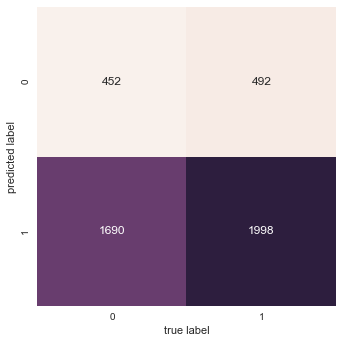

Total True Positive and True Negative: 2450
Total False Positive and False Negative: 2182
Accurancy: 0.528929188256


In [33]:
#plot confusion matrix using Random Forest Classifieds
plot_confusion_matrix(X_test, y_test, RFC)

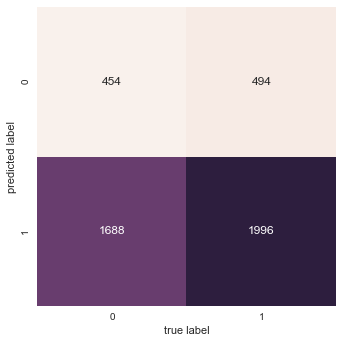

Total True Positive and True Negative: 2450
Total False Positive and False Negative: 2182
Accurancy: 0.528929188256


In [34]:
#plot confusion matrix using Bagging Random Forest Classifieds
plot_confusion_matrix(X_test, y_test, bag)

## Test your models with test values

In [35]:
#Test your models with random values
data = pd.DataFrame({ 
'radiant_int': [3],
'dire_int': [2],
'radiant_str': [1],
'dire_str': [2],
'radiant_agi': [1],
'dire_agi': [1]})

prediction = RFC.predict(data)
prediction_prob = RFC.predict_proba(data)

In [36]:
print(prediction[0])

arr = np.array(prediction_prob)
print('Radiant with percentage: ',arr[0,1])
print('Dire with percentage: ',arr[0,0])

1
Radiant with percentage:  0.535493384284
Dire with percentage:  0.464506615716


## Build a dashboard

In [37]:
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets
from IPython.html.widgets import interact

C:\Users\pho01\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [38]:
def select_model(model):
    if(model == '0'):
        model = RFC
    elif(model == '1'):
        model = bag
    elif(model == '3'):
        model = GNB
    elif(model == '4'):
        model = knn
    elif(model == '5'):
        model = mlpclass
    else:
        model = RFC
    return model

def create_plot(selected_model, rad_int, rad_str, rad_agi, dire_int, dire_str, dire_agi):
    
    print_line()
    
    total_rad = rad_int + rad_str + rad_agi
    total_dire = dire_int + dire_str + dire_agi
    
    if(total_rad != 5):
        print('Error: Radiant team must be exactly 5 heroes')
    
    elif(total_dire != 5):
        print('Error: Dire team must be exactly 5 heroes')
    
    else:
        data = pd.DataFrame({ 
        'radiant_int': [rad_int],
        'dire_int': [dire_int],
        'radiant_str': [rad_str],
        'dire_str': [dire_str],
        'radiant_agi': [rad_agi],
        'dire_agi': [dire_agi]})
        
        model = select_model(selected_model)
        
        prediction = model.predict(data)
        prediction_prob = model.predict_proba(data)

        if(prediction[0] == 1):
            team = 'Radiant'
        else:
            team = 'Dire'

        arr = np.array(prediction_prob)

        RADIANT_PERCENTAGE = round(float(arr[0,1]) * 100)
        DIRE_PERCENTAGE = 100 - RADIANT_PERCENTAGE
        
        print('Radiant: ', RADIANT_PERCENTAGE, '%.', 'Dire: ', DIRE_PERCENTAGE, '%.', team, 'will win')
        
        teams = ['Radiant', 'Dire']
        
        p = figure(x_range=teams, 
                   y_axis_label = 'Percentage (%)',
                   plot_height=350, 
                   title="Probability of team to win")
        p.vbar(x=teams, top=[RADIANT_PERCENTAGE, DIRE_PERCENTAGE], 
               width=0.5, 
               color=['#d53e4f','#fee08b'])
        p.xgrid.grid_line_color = None
        p.y_range.start = 0
        show(p)


In [ ]:
slider_rad_int = widgets.IntSlider(value=1,min=0,max=5,step=1,description='Radiant Int:')
slider_rad_str = widgets.IntSlider(value=2,min=0,max=5,step=1,description='Radiant Str:')
slider_rad_agi = widgets.IntSlider(value=2,min=0,max=5,step=1,description='Radiant Agi:')
slider_dire_int = widgets.IntSlider(value=1,min=0,max=5,step=1,description='Dire Int:')
slider_dire_str = widgets.IntSlider(value=2,min=0,max=5,step=1,description='Dire Str:')
slider_dire_agi = widgets.IntSlider(value=2,min=0,max=5,step=1,description='Dire Agi:')

choose_task = widgets.Dropdown(
    options={'Random Forest Classifier': '0', 
             'Bagging with Random Classifier': '1', 
             'Naive Bayes': '3',
             'KNN' : '4',
             'Neural Network Classified' : '5'
            },
    value='0',
    description='Model Selection:',
)

interactive_plot = interactive(create_plot, selected_model=choose_task,
                               rad_int=slider_rad_int, rad_str=slider_rad_str, rad_agi=slider_rad_agi,
                               dire_int=slider_dire_int, dire_str=slider_dire_str, dire_agi=slider_dire_agi,
                              )


output = interactive_plot.children[-1]
output.layout.height = '700px'
output.layout.width = '800px'

interactive_plot